<a href="https://colab.research.google.com/github/Dandyeriametor/AI-Project/blob/main/AI_Final_Project_fraud_detection_project_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI-Final Project

# Author: Dandy Eriametor

# Business Intelligence Analyst

# Student Number: DE111080



# Fraud Detection with Machine Learning (Anomaly Detection)

This Colab notebook implements an end-to-end fraud detection pipeline on the **`Fraud Detection.csv`** dataset.

It covers:
- Problem definition and dataset loading
- Data cleaning, preprocessing, and exploratory data analysis (EDA)
- Model selection and development (Random Forest as the main model)
- Hyperparameter tuning with GridSearchCV
- Model evaluation using appropriate metrics
- A simple "deployment-style" prediction interface inside the notebook


## 1. Setup and Imports

We first import all required Python libraries for data handling, visualization, and modeling.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    RocCurveDisplay,
)

import warnings
warnings.filterwarnings('ignore')

sns.set(style='whitegrid', context='notebook')

## 2. Problem Definition

We focus on the real-world problem of **detecting fraudulent online activity**, framed as a highly **imbalanced binary classification** task:

- **Positive class**: Fraudulent transactions (rare events / anomalies)
- **Negative class**: Safe / legitimate transactions

The goal is to train a machine learning model that can identify suspicious transactions and distinguish them from normal ones.


## 3. Load and Inspect the Dataset

Upload the provided `Fraud Detection.csv` file into the Colab environment.

You can upload it using the file upload widget below.


In [5]:
from google.colab import files

uploaded = files.upload()  # Upload Fraud Detection.csv

# Automatically pick the first uploaded file
csv_name = list(uploaded.keys())[0]
df = pd.read_csv(csv_name)

print('Shape:', df.shape)
df.head()

Saving Fraud Detection.csv to Fraud Detection (1).csv
Shape: (10127, 20)


,step,type,branch,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,unusuallogin,isFlaggedFraud,Acct type,Date of transaction,Time of day,isFraud,Column1,isFraud - Copy,DayOfWeek,DayOfWeek(new)
0,7,PAYMENT,Espana,1526.50,C1908839976,0.0,0.0,M1304522697,0.0,0.0,7,0,Savings,03-Jan-18,Afternoon,Safe,7168,0.0,3.0,Wednesday
1,7,PAYMENT,Honduras,1620.17,C70432899,0.0,0.0,M252297858,0.0,0.0,2,0,Savings,05-Jan-18,Night,Safe,7211,0.0,5.0,Friday
2,7,PAYMENT,Indonesia,5689.82,C332151172,0.0,0.0,M1430674428,0.0,0.0,3,0,Savings,07-Jan-18,Morning,Safe,7268,0.0,7.0,Sunday
3,7,PAYMENT,Estados Unidos,2211.07,C1148172078,0.0,0.0,M650835126,0.0,0.0,13,0,Savings,06-Jan-18,Afternoon,Safe,7325,0.0,6.0,Saturday
4,7,PAYMENT,Estados Unidos,824.63,C1142006014,0.0,0.0,M745868137,0.0,0.0,7,0,Savings,06-Jan-18,Morning,Safe,7326,0.0,6.0,Saturday


### 3.1 Basic Info and Class Distribution

We check data types, missing values, and the distribution of the fraud label.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   step                 10127 non-null  int64  
 1   type                 10123 non-null  object 
 2   branch               10127 non-null  object 
 3   amount               10125 non-null  float64
 4   nameOrig             10121 non-null  object 
 5   oldbalanceOrg        10125 non-null  float64
 6   newbalanceOrig       10127 non-null  float64
 7   nameDest             10121 non-null  object 
 8   oldbalanceDest       10126 non-null  float64
 9   newbalanceDest       10125 non-null  float64
 10  unusuallogin         10127 non-null  int64  
 11  isFlaggedFraud       10127 non-null  int64  
 12  Acct type            10117 non-null  object 
 13  Date of transaction  10120 non-null  object 
 14  Time of day          10125 non-null  object 
 15  isFraud              10127 non-null 

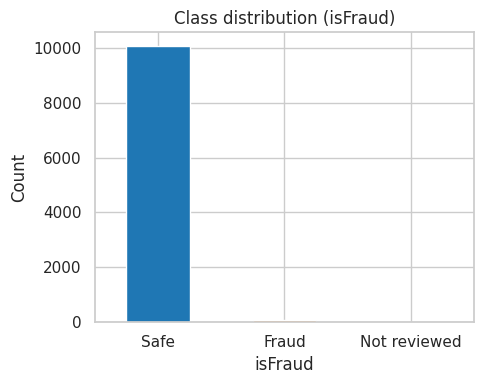

In [6]:
df.info()
print('\nMissing values per column:')
print(df.isna().sum())

print('\n`isFraud` value counts:')
print(df['isFraud'].value_counts())

print('\n`isFraud - Copy` value counts (numeric target):')
print(df['isFraud - Copy'].value_counts())

# Plot class distribution
plt.figure(figsize=(5,4))
df['isFraud'].value_counts().plot(kind='bar', color=['tab:blue', 'tab:orange', 'tab:green'])
plt.title('Class distribution (isFraud)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

We see that fraudulent transactions are **rare compared to safe ones**, which is typical of anomaly detection / fraud detection problems. The column `isFraud - Copy` is a numeric representation of `isFraud` where 1.0 indicates fraud and 0.0 indicates safe.


## 4. Data Cleaning and Preprocessing

We will:

- Rename some columns to make them easier to work with in Python
- Drop identifier-like columns that are unlikely to help (e.g., account IDs)
- Select relevant features and define the target variable.


In [8]:
# Rename columns for convenience
df = df.rename(columns={
    'Acct type': 'acct_type',
    'Date of transaction': 'date',
    'Time of day': 'time_of_day',
    'isFraud - Copy': 'is_fraud_num',
    'DayOfWeek(new)': 'day_name'
})

df.columns

Index(['step', 'type', 'branch', 'amount', 'nameOrig', 'oldbalanceOrg',
       'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest',
       'unusuallogin', 'isFlaggedFraud', 'acct_type', 'date', 'time_of_day',
       'isFraud', 'Column1', 'is_fraud_num', 'DayOfWeek', 'day_name'],
      dtype='object')

We drop ID-like and redundant columns such as `nameOrig`, `nameDest`, `Column1`, and the string label `isFraud` once we have the numeric label `is_fraud_num`.


In [9]:
drop_cols = ['nameOrig', 'nameDest', 'Column1', 'date', 'isFraud']
df_model = df.drop(columns=drop_cols)

df_model.head()

,step,type,branch,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,unusuallogin,isFlaggedFraud,acct_type,time_of_day,is_fraud_num,DayOfWeek,day_name
0,7,PAYMENT,Espana,1526.50,0.0,0.0,0.0,0.0,7,0,Savings,Afternoon,0.0,3.0,Wednesday
1,7,PAYMENT,Honduras,1620.17,0.0,0.0,0.0,0.0,2,0,Savings,Night,0.0,5.0,Friday
2,7,PAYMENT,Indonesia,5689.82,0.0,0.0,0.0,0.0,3,0,Savings,Morning,0.0,7.0,Sunday
3,7,PAYMENT,Estados Unidos,2211.07,0.0,0.0,0.0,0.0,13,0,Savings,Afternoon,0.0,6.0,Saturday
4,7,PAYMENT,Estados Unidos,824.63,0.0,0.0,0.0,0.0,7,0,Savings,Morning,0.0,6.0,Saturday


### 4.1 Define Features and Target

- **Target**: `is_fraud_num` (0 = Safe, 1 = Fraud)
- **Features**: All remaining columns except the target.


In [11]:
# Drop rows where target is NaN
df_model = df_model.dropna(subset=['is_fraud_num'])

# Now convert
y = df_model['is_fraud_num'].astype(int)
X = df_model.drop(columns=['is_fraud_num'])

print("Features shape:", X.shape)
print("Target distribution:")
print(y.value_counts())

Features shape: (10125, 14)
Target distribution:
is_fraud_num
0    10057
1       68
Name: count, dtype: int64


### 4.2 Identify Numeric and Categorical Features

We will apply different preprocessing steps to numeric and categorical columns:

- Numeric: Standard scaling (optional, but can help some models)
- Categorical: One-hot encoding


In [12]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print('Numeric features:', numeric_features)
print('Categorical features:', categorical_features)

Numeric features: ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'unusuallogin', 'isFlaggedFraud', 'DayOfWeek']
Categorical features: ['type', 'branch', 'acct_type', 'time_of_day', 'day_name']


### 4.3 Train-Test Split

We split the data into training and test sets, stratifying by the fraud label so that the class imbalance is preserved.


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((8100, 14), (2025, 14))

## 5. Model Selection and Pipeline (Random Forest)

Fraud detection can be viewed as **anomaly detection** because fraudulent transactions are rare. Here we use a **Random Forest classifier** with class weighting to handle imbalance, and we treat fraud as the minority class.

We use a `ColumnTransformer` to apply preprocessing inside a `Pipeline`:

- Numeric features: `StandardScaler`
- Categorical features: `OneHotEncoder`
- Classifier: `RandomForestClassifier(class_weight='balanced')`


In [14]:
from sklearn.impute import SimpleImputer

# Preprocess numeric and categorical columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ]
)

# Base Random Forest model
rf_clf = RandomForestClassifier(
    random_state=42,
    class_weight='balanced',  # handle class imbalance
    n_jobs=-1
)

rf_pipe = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', rf_clf)
])

rf_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['step', 'amount',
                                                   'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest',
                                                   'unusuallogin',
                                                   'isFlaggedFraud',
                                                   'DayOfWeek']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['type', 'branch',
                                                   'acct_type', 'time_of_day',
                                                   'day_name'])])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        random_state=42))])

### 5.1 Hyperparameter Tuning with GridSearchCV

We define a parameter grid and perform a grid search to find the best Random Forest configuration.


In [15]:
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    estimator=rf_pipe,
    param_grid=param_grid,
    cv=3,
    scoring='roc_auc',  # AUC is meaningful for imbalanced binary problems
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print('Best parameters:', grid_search.best_params_)
print('Best CV ROC-AUC:', grid_search.best_score_)

best_model = grid_search.best_estimator_

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
Best CV ROC-AUC: 0.9981736956942028


## 6. Model Evaluation

We evaluate the tuned Random Forest model on the **test set** using several metrics:

- Accuracy
- Precision, Recall, F1-score (with fraud as the positive class)
- Confusion matrix
- ROC-AUC


Accuracy: 0.9946
Precision (Fraud): 1.0000
Recall (Fraud): 0.2143
F1-score (Fraud): 0.3529

Classification report:
              precision    recall  f1-score   support

        Safe       0.99      1.00      1.00      2011
       Fraud       1.00      0.21      0.35        14

    accuracy                           0.99      2025
   macro avg       1.00      0.61      0.68      2025
weighted avg       0.99      0.99      0.99      2025



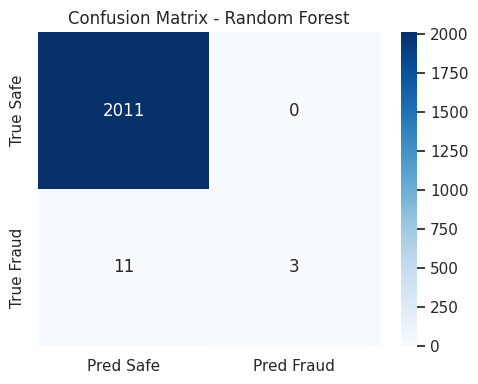

ROC-AUC: 0.9534


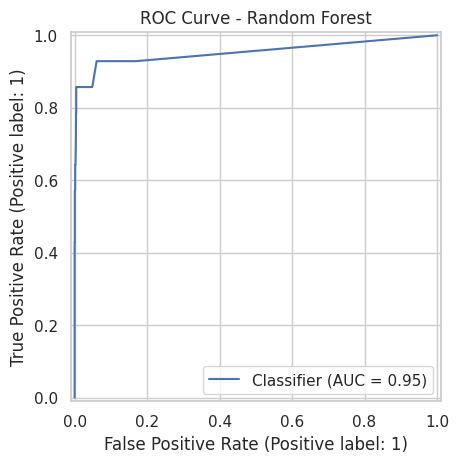

In [16]:
y_pred = best_model.predict(X_test)

# Some metrics focus on the positive (fraud) class
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print(f"Accuracy: {acc:.4f}")
print(f"Precision (Fraud): {prec:.4f}")
print(f"Recall (Fraud): {rec:.4f}")
print(f"F1-score (Fraud): {f1:.4f}")

print('\nClassification report:')
print(classification_report(y_test, y_pred, target_names=['Safe', 'Fraud'], zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred Safe', 'Pred Fraud'],
            yticklabels=['True Safe', 'True Fraud'])
plt.title('Confusion Matrix - Random Forest')
plt.tight_layout()
plt.show()

# ROC-AUC (if probability estimates available)
y_proba = best_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC: {auc:.4f}")

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title('ROC Curve - Random Forest')
plt.show()

## 7. Feature Importance Visualization

We inspect the feature importances from the Random Forest to understand which features influence the fraud prediction the most.


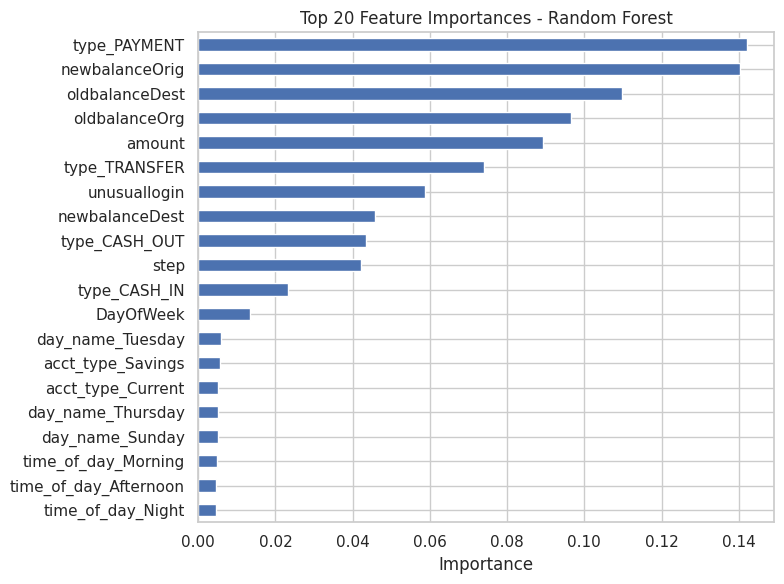

,0
type_PAYMENT,0.142023
newbalanceOrig,0.140192
oldbalanceDest,0.109865
oldbalanceOrg,0.096531
amount,0.089302
type_TRANSFER,0.074028
unusuallogin,0.058832
newbalanceDest,0.045860
type_CASH_OUT,0.043486
step,0.042137


In [17]:
# Extract the trained RF model from the pipeline
rf_final = best_model.named_steps['clf']
importances = rf_final.feature_importances_

# Retrieve feature names after preprocessing
ohe = best_model.named_steps['preprocess'].named_transformers_['cat'].named_steps['onehot']
cat_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_features, cat_feature_names])

feat_imp = pd.Series(importances, index=all_feature_names).sort_values(ascending=False)

topN = 20
plt.figure(figsize=(8,6))
feat_imp.head(topN).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title(f'Top {topN} Feature Importances - Random Forest')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

feat_imp.head(topN)

## 8. Simple Deployment-Style Prediction Function

We now build a helper function `predict_transaction` that mimics a small deployment interface. It:

- Accepts a dictionary representing a single transaction
- Converts it to a `DataFrame` with the correct columns
- Uses the trained pipeline to predict whether the transaction is fraud or safe
- Returns both the predicted label and the fraud probability


In [18]:
def predict_transaction(model, sample_dict):
    """Predict fraud vs safe for a single transaction represented as a dict.

    sample_dict keys must match the original feature column names in X.
    """
    sample_df = pd.DataFrame([sample_dict])
    proba = model.predict_proba(sample_df)[0, 1]
    pred = model.predict(sample_df)[0]
    label = 'Fraud' if pred == 1 else 'Safe'
    return label, proba

# Build an example using median / mode values from training data as a template
example = {}
for col in numeric_features:
    example[col] = float(X_train[col].median())
for col in categorical_features:
    example[col] = X_train[col].mode()[0]

label, proba = predict_transaction(best_model, example)
print('Predicted label:', label)
print('Fraud probability:', proba)

Predicted label: Safe
Fraud probability: 0.0


You can modify the `example` dictionary (e.g., higher `amount`, unusual branch or time of day) and re-run the cell to see how the fraud probability changes. This serves as a simple interactive interface within the notebook.


## 9. Further Findings

Possible extensions include:

- Trying other models such as Gradient Boosting, XGBoost, or Isolation Forest for anomaly detection
- Calibrating probabilities and setting decision thresholds to balance false positives vs false negatives

